/tmp/ipykernel_919181/2670706702.py:4: DeprecationWarning: `photutils.CircularAnnulus` is a deprecated alias for `photutils.aperture.CircularAnnulus` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAnnulus` to silence this warning.
  from photutils import CircularAnnulus, aperture_photometry
/tmp/ipykernel_919181/2670706702.py:4: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import CircularAnnulus, aperture_photometry
/tmp/ipykernel_919181/2670706702.py:5: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import Ci

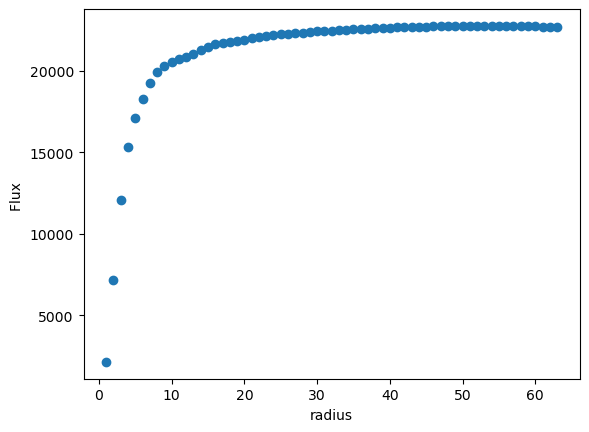

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from photutils import CircularAnnulus, aperture_photometry
from photutils import CircularAperture
from scipy.ndimage import center_of_mass

hdulist = fits.open('object.fits')
data = hdulist[0].data


y, x = np.indices(data.shape)
center_x = (x*data).sum()/data.sum()
center_y = (y*data).sum()/data.sum()


radii = np.arange(1, data.shape[0]//2, 1)


fluxes = []
for r in radii:
    aperture = CircularAperture((center_x, center_y), r=r)
    phot_table = aperture_photometry(data, aperture)
    fluxes.append(phot_table['aperture_sum'][0])



center = center_of_mass(data)
r = np.sqrt((x - center_x)**2 + (y - center_y)**2)

plt.scatter(radii, fluxes)
plt.xlabel('radius')
plt.ylabel('Flux ')
plt.show()


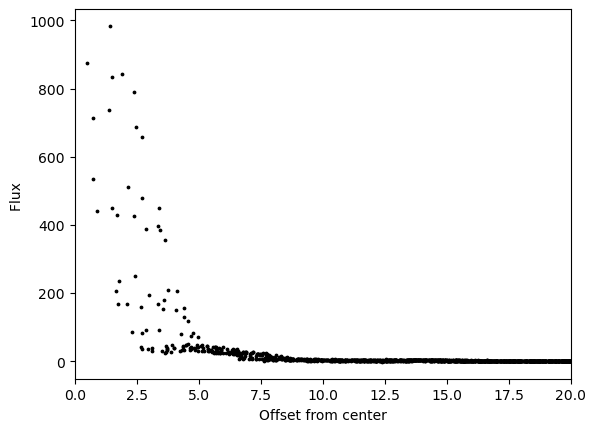

In [4]:
r = np.sqrt((x - center_x)**2 + (y - center_y)**2)

data_flat = data.flatten()
r_flat = r.flatten()

plt.xlim([0,20])
plt.scatter(r_flat, data_flat,c='black', s=3)
plt.xlabel('Offset from center')
plt.ylabel('Flux ')
plt.show()


In [5]:

radius = data.shape[0]//2


aperture = CircularAperture((center_x, center_y), r=radius)


phot_table = aperture_photometry(data, aperture)


print(phot_table['aperture_sum'])


   aperture_sum   
------------------
22716.379215934103


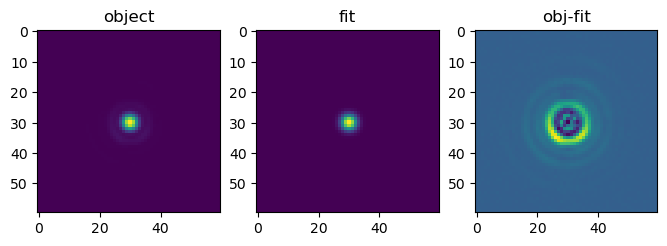

In [6]:
from astropy.modeling import models, fitting


image = fits.getdata('object.fits')
cents = np.where(image == np.max(image))
xc = int(cents[1])
yc = int(cents[0])

bb = 30
box = image[yc-bb:yc+bb, xc-bb:xc+bb]

threshold = 0.0038


box[box < threshold] = 0
yp, xp = box.shape

y, x, = np.mgrid[:yp, :xp]
f_init = models.Gaussian2D()
fit_f = fitting.LevMarLSQFitter()
f = fit_f(f_init, x, y, box)


#-3?*stdev=65.9411
#scale
#area under gaussian


plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(box)
plt.title("object")
plt.subplot(1, 3, 2)
plt.imshow(f(x, y))
plt.title("fit")
plt.subplot(1, 3, 3)
plt.imshow(box - f(x, y))
plt.title("obj-fit")
plt.show()


In [7]:
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder, extract_stars
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils import MMMBackground, BasicPSFPhotometry
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm




data = data.astype(float)
mean, median, std = sigma_clipped_stats(data)
data -= median

# Convert the data to an NDData object
data = NDData(data)

mean, median, std = sigma_clipped_stats(data.data)
daofind = DAOStarFinder(fwhm=7.0, threshold=5.*std)
sources = daofind(data.data)
sources.rename_column('xcentroid', 'x')
sources.rename_column('ycentroid', 'y')


cutouts = extract_stars(data, sources, size=21)
psf_model = IntegratedGaussianPRF(sigma=3.0)
sigma=3.0

daogroup = DAOGroup(2.0*sigma*gaussian_sigma_to_fwhm)


fitter = LevMarLSQFitter()
sources.rename_column('x', 'x_0')
sources.rename_column('y', 'y_0')
photometry = BasicPSFPhotometry(group_maker=daogroup,bkg_estimator=MMMBackground(),psf_model=psf_model,fitter=LevMarLSQFitter(),fitshape=(11,11))


result_tab = photometry(image=data.data, init_guesses=sources)


print(result_tab)


/tmp/ipykernel_919181/1716130519.py:3: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder, extract_stars
/tmp/ipykernel_919181/1716130519.py:3: DeprecationWarning: `photutils.extract_stars` is a deprecated alias for `photutils.psf.extract_stars` and will be removed in the future. Instead, please use `from photutils.psf import extract_stars` to silence this warning.
  from photutils import DAOStarFinder, extract_stars
/tmp/ipykernel_919181/1716130519.py:5: DeprecationWarning: `photutils.MMMBackground` is a deprecated alias for `photutils.background.MMMBackground` and will be removed in the future. Instead, please use `from photutils.background import MMMBackground` to silence this warning.
  from photutils import MMMBackground, BasicPSFPhotometry
/tmp/ipykernel_919181

 id        x_0         ...        y_fit              flux_fit     
--- ------------------ ... ------------------- -------------------
  1  66.10660990874962 ... -100.18282076619172 -1853.1445389280675
  2 62.073615674787675 ...   67.69784093203006  150.37036723856193
  3  56.99443244372223 ...   81.14112452159124  27273.526353664925
